Jmeno: Ondrej Lukasek
Login: xlukas15
mail: xlukas15@stud.fit.vutbr.cz

Zacneme importem jednotlivych knihoven, ktere budou v projektu potreba.

In [111]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

from IPython.display import Audio

Nyni nacteme vsechny jednotlive tony (respektive cely soubor klavir.waw), jak je napsano v zadani.
Pro nacteni jednotlivych tonu pouziji navod ze zadani.

In [112]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.35
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read('klavir.wav')
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) # matrix with all tones - first signals empty,
# but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x) # safer to center ...
    xall[tone,:] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone

Tony pro muj login (xlukas15) jsou 40; 76 a 105, ty si postupne ulozim do souboru, pojmenovanych podle zadani (a_orig.wav, b_orig.wav, c_orig.wav), a ulozim je do slozky audio.

In [113]:
sf.write('audio/a_orig.wav', xall[40], Fs)
sf.write('audio/b_orig.wav', xall[76], Fs)
sf.write('audio/c_orig.wav', xall[105], Fs)


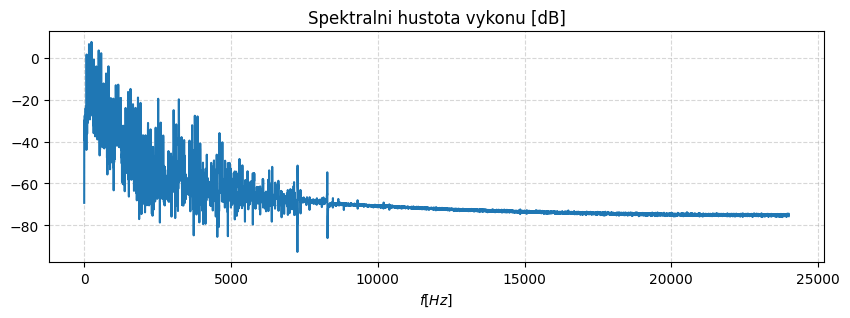

In [114]:
s, Fs = sf.read('audio/a_orig.wav') # POTREBA ZOBRAZIT JENOM 3 PERIODY
display(Audio(s, rate=Fs)) # pozdeji potreba smazat
N = s.size
s_seg_spec = np.fft.fft(s)
G = 10 * np.log10(1/N * np.abs(s_seg_spec)**2)

f = np.arange(G.size) / N * Fs

plt.figure(figsize=(10, 3))
#plt.plot(f[:f.size//2+1], G[:G.size//2+1])
plt.plot(f[:f.size//2+1], G[:G.size//2+1])
#plt.plot(f, G)

plt.xlabel('$f[Hz]$')
plt.title('Spektralni hustota vykonu [dB]')
plt.grid(alpha=0.5, linestyle='--')



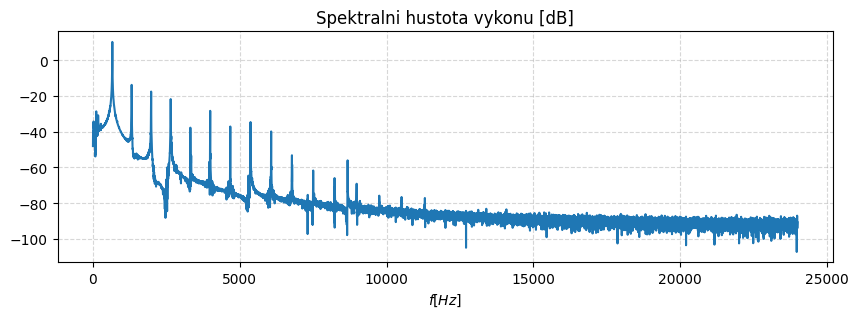

In [115]:
s, Fs = sf.read('audio/b_orig.wav') # POTREBA ZOBRAZIT JENOM 3 PERIODY
display(Audio(s, rate=Fs)) # pozdeji potreba smazat
N = s.size
s_seg_spec = np.fft.fft(s)
G = 10 * np.log10(1/N * np.abs(s_seg_spec)**2)

f = np.arange(G.size) / N * Fs

plt.figure(figsize=(10, 3))
#plt.plot(f[:f.size//2+1], G[:G.size//2+1])
plt.plot(f[:f.size//2], G[:G.size//2])
#plt.plot(f, G)

plt.xlabel('$f[Hz]$')
plt.title('Spektralni hustota vykonu [dB]')
plt.grid(alpha=0.5, linestyle='--')

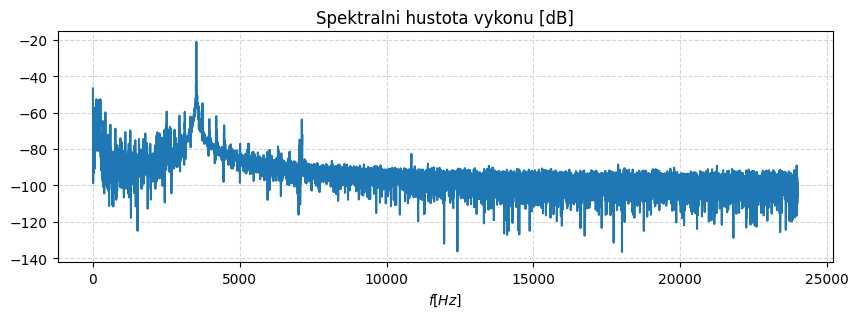

In [116]:
s, Fs = sf.read('audio/c_orig.wav') # POTREBA ZOBRAZIT JENOM 3 PERIODY
display(Audio(s, rate=Fs)) # pozdeji potreba smazat
N = s.size
s_seg_spec = np.fft.fft(s)
G = 10 * np.log10(1/N * np.abs(s_seg_spec)**2)

f = np.arange(G.size) / N * Fs

plt.figure(figsize=(10, 3))
#plt.plot(f[:f.size//2+1], G[:G.size//2+1])
plt.plot(f[:f.size//2], G[:G.size//2])
#plt.plot(f, G)

plt.xlabel('$f[Hz]$')
plt.title('Spektralni hustota vykonu [dB]')
plt.grid(alpha=0.5, linestyle='--')